*Revised version: instead of considering just the synapse values alone, we consider instead synapses/unmasked, as per Greg's explanation of the unmasked variable*

### Define Model


Call a row vector from our data set $X_i=(x_i, y_i, z_i, u_i, s_i)$ where positions are respective to those in the original data set. Each row vector represents a 'bin' of pixels, let the number of rows in the data correspond to N. We will look at the number of synapses per bin, and whether the number follows a uniform distribution, conditioned on unmasked.

### Assumptions
The number of synapses per bin follows a multinomial distribution, where the probability of synapses is conditioned on the unmasked value for that bin. 

### Statistical test

We will test whether or not the number of synapses are distributed uniformly across each bin. In other words does X follow a multinomial distribution where each cell has equal probabilities.

$H_0: \textrm{ all cells have equal probability }$

$H_A: \textrm{ cells do not have equal probability }$


### Test statistic 
We'll use Pearson's Chi Squared Test to determine whether to reject the null. First, define $\bar \pi$ to be the average synaptic density (synapse/unmasked) across all bins. Let $E_i$, the expected number of synapses at bin i, be $E_i=\bar \pi u_i$ where $u_i$ is unmasked value at that bin. Let $X_i$ be the observed number of synapses.
Our test statistic is as follows
$$
T = \sum_{i = 1}^{N} \frac{(X_i - E_i)^2}{X_i}
$$

and it approximately follows a chi-squared distribution with N-1 degrees of freedom. Therefore, given a signifigance level, $\alpha$, we can use the inverse CDF of the chi-squared distribution to determine a critical value. When T is greater than the critical value, we can reject the null.

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import urllib2
import scipy.stats as stats

%matplotlib inline

np.set_printoptions(precision=3, threshold=1000000, suppress=True)
np.random.seed(1)
alpha = .025
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)
num_samples = 150 # how many different sized samples to draw
N = np.sum(csv[:, -1]) # total data set size
L = np.unique(csv[:, 2]) # list of labels
print L.shape

# sample sizes to iterate over
sample_sizes = np.logspace(1.0, 5.0, num=num_samples, base=10.0)
print sample_sizes

(11,)
[     10.         10.638      11.316      12.038      12.805      13.622
      14.49       15.414      16.397      17.443      18.555      19.738
      20.997      22.335      23.76       25.275      26.886      28.601
      30.424      32.364      34.428      36.623      38.959      41.443
      44.085      46.897      49.887      53.068      56.452      60.051
      63.881      67.954      72.287      76.896      81.8        87.016
      92.564      98.467     104.745     111.424     118.529     126.087
     134.127     142.68      151.778     161.456     171.751     182.703
     194.353     206.746     219.929     233.952     248.87      264.74
     281.621     299.578     318.681     339.001     360.618     383.612
     408.073     434.094     461.774     491.219     522.542     555.861
     591.306     629.01      669.119     711.785     757.172     805.453
     856.813     911.447     969.566    1031.39     1097.156    1167.116
    1241.537    1320.704    1404.918    1494.5

### Step 4a: Sample data from null

In [23]:
# simulated sampling under the null
repeats = 100 # how many repitions per sample size
pi_null = np.array([1.0/float(len(L))]*len(L)) # pi vector under the null (uniform probs)
power_null = []
for s in sample_sizes:
    power = 0
    E_i = pi_null*s # expected per label
    for r in xrange(repeats):
        null_data = np.random.multinomial(s, pi_null)
        chi_sq = stats.chisquare(null_data, E_i)
        p_value = chi_sq[1]
        # can we reject the null hypothesis
        if p_value < alpha:
            power = power + 1
    power_null.append(float(power)/float(repeats))


### Step 4b: Sample data from alternate

In [24]:
# simulated sampling under alternate
repeats = 100 # how many repitions per sample size
power_alt = []
pi_alt = np.random.rand(len(L)) # create a pi vector (random probabilities)
pi_alt = pi_alt/np.sum(pi_alt) # normalize
for s in sample_sizes:
    power = 0
    E_i = pi_null*s # all labels have equal expectancy
    for r in xrange(repeats):
        alt_data = np.random.multinomial(s, pi_alt) # use pi vector to gen data
        chi_sq = stats.chisquare(alt_data, E_i)
        p_value = chi_sq[1]
        # can we reject the null hypothesis
        if p_value < alpha:
            power = power + 1
    power_alt.append(float(power)/float(repeats))

### Step 5: Plot power vs n

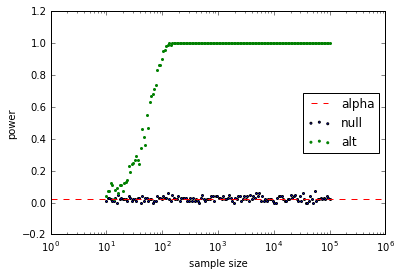

In [27]:
plt.scatter(sample_sizes, power_null, hold=True, label='null', s=4)
plt.scatter(sample_sizes, power_alt, color='green', hold=True, label='alt', s=4)
plt.xlabel('sample size')
plt.xscale('log')
plt.ylabel('power')
plt.axhline(alpha, color='red', linestyle='--', label='alpha')
plt.legend(loc=5)
plt.show()

### Apply to data

In [11]:
from __future__ import division
csv = csv[np.where(csv[:, -2] != 0)]
X = csv[:, -1]
density = csv[:, -1]/csv[:,-2]
# get average density (probability)
avg = np.average(density)
# expected values are everage probability multipled by unmasked per bin
E = csv[:, -2]*avg
print X[:50]
print E[:50]
print stats.chisquare(X, E)

[  0.   0.   0.   0.   0.  17.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  13.   0.   0.   0.   0.   1.   0.   0.   0.   0.  16.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.  21.   0.   0.   0.   1.   0.   0.   0.   0.
   0.   0.  17.   0.   0.]
[  5.263   3.717   4.741   1.581   1.581  15.53    1.581   4.743   1.242
   4.743   4.953   4.002   4.719   1.581   1.581  15.255   1.581   4.743
   1.139   4.743   5.048   4.081   4.743   1.581   1.581  14.965   1.581
   4.743   0.899   4.743   0.456   6.341   4.164   4.724   1.581   1.581
  14.563   1.581   4.743   0.756   4.743   1.581   6.36    4.349   4.743
   1.581   1.581  14.356   1.581   4.743]
Power_divergenceResult(statistic=1080693.9012075576, pvalue=0.0)


### Reflect

Thus we reject the null hypothesis that the synapses are uniformly distributed.